In [121]:
import pandas as pd
#import sklearn
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from pprint import pprint
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pickle
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
import warnings
from scipy.stats import pearsonr

pd.options.mode.chained_assignment = None  # default='warn'
shap.initjs()

In [122]:
df = pd.read_csv('data/US/counties.csv')
df = df.rename(columns = lambda x: x.lower().replace('-','_'))
df_16 = df[df.year == 2016]
df_16.dropna(inplace=True)
df_16.reset_index(inplace = True)
#df_16 = sklearn.utils.shuffle(df_16, random_state=42)

In [123]:
# Incorporate public health insurance
df_pubhealth = pd.read_csv('data/census/ALLOCATION OF PUBLIC HEALTH INSURANCE/ACS_16_5YR_B992703_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_pubhealth.columns = df_pubhealth.columns.droplevel(0)
renames = {}
for col in df_pubhealth.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]

df_pubhealth = df_pubhealth.rename(columns = renames)
drops = ['Id','Geography','Total','Total_No_public_coverage_items_allocated']
df_pubhealth.drop(drops, axis=1, inplace=True)
df_pubhealth.dropna(inplace=True)

In [124]:
df_16 = pd.merge(df_16, df_pubhealth, how = 'inner', left_on= 'geoid', right_on= 'Id2')
df_16['pct_public_health_insurance'] = df_16['Total_One_or_more_public_coverage_items_allocated']/df_16['population']
df_16.drop('Total_One_or_more_public_coverage_items_allocated', axis=1, inplace=True)

In [125]:
# Incorporate private health insurance
df_privhealth = pd.read_csv('data/census/ALLOCATION OF PRIVATE HEALTH INSURANCE/ACS_16_5YR_B992702_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_privhealth.columns = df_privhealth.columns.droplevel(0)
renames = {}
for col in df_privhealth.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]

df_privhealth = df_privhealth.rename(columns = renames)
drops = ['Id','Geography','Total','Total_No_private_health_insurance_items_allocated']
df_privhealth.drop(drops, axis=1, inplace=True)
df_privhealth.dropna(inplace=True)

In [126]:
df_16 = pd.merge(df_16, df_privhealth, how = 'inner', left_on= 'geoid', right_on= 'Id2')
df_16['pct_private_health_insurance'] = df_16['Total_One_or_more_private_health_insurance_items_allocated']/df_16['population']
df_16.drop('Total_One_or_more_private_health_insurance_items_allocated', axis=1, inplace=True)

In [127]:
# Incorporate household type
df_household = pd.read_csv('data/census/HOUSEHOLD TYPE/ACS_16_5YR_B11001_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_household.columns = df_household.columns.droplevel(0)

renames = {}
for col in df_household.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]
df_household = df_household.rename(columns = renames)

drops = ['Id','Geography']
for col in df_household.columns:
    if 'Margin' in col:
        drops.append(col)
df_household.drop(drops, axis=1, inplace = True)
df_household.dropna(inplace=True)
df_household.rename(columns={'Family_households_Other_family_Female_householder,_no_husband_present':
                           'Female_householder,_no_husband_present'}, inplace=True)

In [128]:
df_htemp = df_household.drop(['Id2','Total'],axis=1).div(df_household['Total'],axis=0)
df_htemp['Id2'] = df_household['Id2']
df_16 = pd.merge(df_16, df_htemp, how = 'inner', left_on= 'geoid', right_on= 'Id2')

In [129]:
# Incorporate transportation by sex
df_transport = pd.read_csv('data/census/SEX OF WORKERS BY MEANS OF TRANSPORTATION TO WORK/ACS_16_5YR_B08006_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_transport.columns = df_transport.columns.droplevel(0)

renames = {}
for col in df_transport.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]
df_transport = df_transport.rename(columns = renames)

drops = ['Id','Geography']
for col in df_transport.columns:
    if 'Margin' in col:
        drops.append(col)
df_transport.drop(drops, axis=1, inplace = True)
df_transport.dropna(inplace=True)

In [130]:
df_ttemp = df_transport.drop(['Id2','Total'],axis=1).div(df_transport['Total'], axis=0)
df_ttemp['Id2'] = df_transport['Id2']
df_16 = pd.merge(df_16, df_ttemp, how = 'inner', left_on= 'geoid', right_on= 'Id2')

# Predicting eviction rate with ml

In [131]:
y = df_16['eviction_filing_rate']
X = df_16.drop(['index','year','population','renter_occupied_households',
               'eviction_filings','evictions','eviction_rate', #'low_flag', 'imputed', 'subbed',
               'eviction_filing_rate','Id2_x','Id2_y'], axis=1)
#X = df_16[['poverty_rate','pct_renter_occupied','median_gross_rent',
#          'median_household_income','median_property_value','rent_burden','pct_white','pct_af_am','pct_hispanic',
#          'pct_am_ind','pct_asian','pct_nh_pi','pct_multiple','pct_other']]
#other columns: ['renter_occupied_households','population']
# create a train/test split
random_state = 42
X_train_geo, X_test_geo, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train = X_train_geo.drop(['geoid','name','parent_location'], axis=1)
X_test = X_test_geo.drop(['geoid','name','parent_location'], axis=1)

# Determine reasonable parameters for XGBoost

In [132]:
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV

In [133]:
#Choose all predictors except target & IDcols
predictors = list(X_train.columns)
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1,min_samples_split=500,
                        min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
                        param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=8,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=50, min_sa...       subsample=0.8, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 81, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [134]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 80}, -17.17459189763771)

In [135]:
param_test2 = {'max_depth':range(1,10,2), 'min_samples_split':range(100,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80,
                                        max_features='sqrt', subsample=0.8, random_state=10), 
                                        param_grid = param_test2, scoring='neg_mean_squared_error',
                                        n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 5, 'min_samples_split': 100}, -16.81265756315919)

In [136]:
param_test3 = {'min_samples_split':range(100,2100,200), 'min_samples_leaf':range(10,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80,
                            max_depth=3,max_features='sqrt', subsample=0.8, random_state=10), 
                            param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 20, 'min_samples_split': 100}, -15.52188625462309)

# XGBoost predictor with no protected class inputs

In [138]:
Xp = X.drop(['pct_white','pct_af_am','pct_hispanic','pct_am_ind','pct_asian','pct_nh_pi',
            'pct_multiple','pct_other','Family_households_Other_family_Male_householder,_no_wife_present',
            'Family_households_Other_family_Male_householder,_no_wife_present',
            'Female_householder,_no_husband_present',
            'Total_Male','Total_Male_Car,_truck,_or_van','Total_Male_Car,_truck,_or_van_Drove_alone',
            'Total_Male_Car,_truck,_or_van_Carpooled','Total_Male_Car,_truck,_or_van_Carpooled_In_2person_carpool',
       'Total_Male_Car,_truck,_or_van_Carpooled_In_3person_carpool',
       'Total_Male_Car,_truck,_or_van_Carpooled_In_4ormoreperson_carpool',
       'Total_Male_Public_transportation_(excluding_taxicab)',
       'Total_Male_Public_transportation_(excluding_taxicab)_Bus_or_trolley_bus',
       'Total_Male_Public_transportation_(excluding_taxicab)_Streetcar_or_trolley_car_(carro_publico_in_Puerto_Rico)',
       'Total_Male_Public_transportation_(excluding_taxicab)_Subway_or_elevated',
       'Total_Male_Public_transportation_(excluding_taxicab)_Railroad',
       'Total_Male_Public_transportation_(excluding_taxicab)_Ferryboat',
       'Total_Male_Bicycle', 'Total_Male_Walked',
       'Total_Male_Taxicab,_motorcycle,_or_other_means',
       'Total_Male_Worked_at_home', 'Total_Female',
       'Total_Female_Car,_truck,_or_van',
       'Total_Female_Car,_truck,_or_van_Drove_alone',
       'Total_Female_Car,_truck,_or_van_Carpooled',
       'Total_Female_Car,_truck,_or_van_Carpooled_In_2person_carpool',
       'Total_Female_Car,_truck,_or_van_Carpooled_In_3person_carpool',
       'Total_Female_Car,_truck,_or_van_Carpooled_In_4ormoreperson_carpool',
       'Total_Female_Public_transportation_(excluding_taxicab)',
       'Total_Female_Public_transportation_(excluding_taxicab)_Bus_or_trolley_bus',
       'Total_Female_Public_transportation_(excluding_taxicab)_Streetcar_or_trolley_car_(carro_publico_in_Puerto_Rico)',
       'Total_Female_Public_transportation_(excluding_taxicab)_Subway_or_elevated',
       'Total_Female_Public_transportation_(excluding_taxicab)_Railroad',
       'Total_Female_Public_transportation_(excluding_taxicab)_Ferryboat',
       'Total_Female_Bicycle', 'Total_Female_Walked',
       'Total_Female_Taxicab,_motorcycle,_or_other_means',
       'Total_Female_Worked_at_home'], axis=1)
Xp_train_geo, Xp_test_geo, yp_train, yp_test = train_test_split(Xp, y, test_size=0.2, random_state=random_state)
Xp_train = Xp_train_geo.drop(['geoid','name','parent_location'], axis=1)
Xp_test = Xp_test_geo.drop(['geoid','name','parent_location'], axis=1)

In [139]:
dp_train = xgb.DMatrix(Xp_train, label=yp_train)
dp_test = xgb.DMatrix(Xp_test, label=yp_test)

paramsp = {
    "eta": 0.5,
    "max_depth": 3,
    "objective": "reg:linear",
    'min_samples_leaf': 30,
    'min_samples_split': 100,
    'n_estimators': 80,
    "silent": 1,
    "base_score": np.mean(yp_train),
    "eval_metric": "rmse",
    'max_features': 'sqrt'
}

modelp = xgb.train(paramsp, dp_train, 10000, 
                  [(dp_train,'train'),(dp_test,'valid')], early_stopping_rounds=200, verbose_eval=1000)

[0]	train-rmse:4.53494	valid-rmse:3.47532
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[7]	train-rmse:3.06481	valid-rmse:3.14848



In [140]:
# compute the SHAP values for every prediction in the validation dataset
explainerp = shap.TreeExplainer(modelp)
shap_valuesp = explainerp.shap_values(Xp_test)

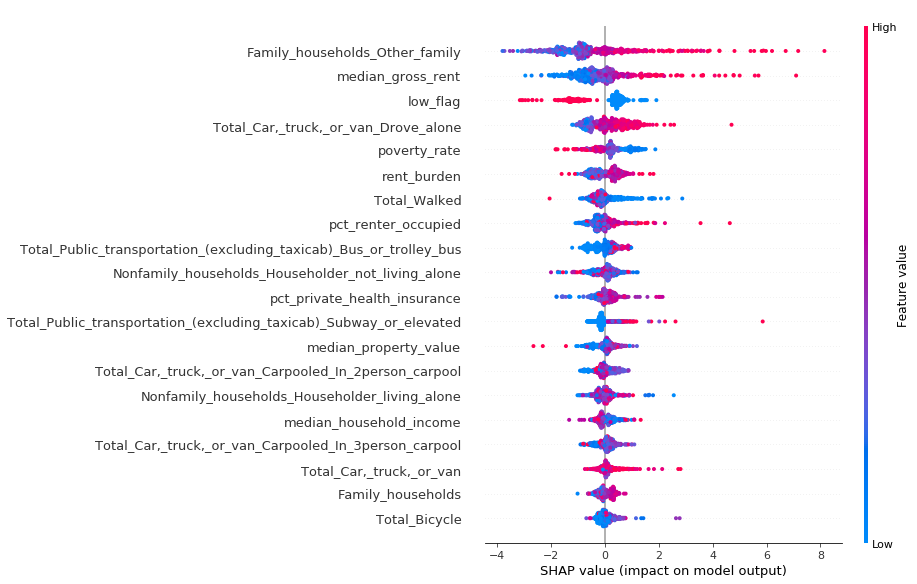

In [141]:
shap.summary_plot(shap_valuesp, Xp_test)

In [142]:
shap.force_plot(explainerp.expected_value, shap_valuesp[60,:], Xp_test.iloc[60,:])

# Predict evictions with protected class variables included

In [143]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

params = {
    "eta": 0.5,
    "max_depth": 3,
    "objective": "reg:linear",
    'min_samples_leaf': 30,
    'min_samples_split': 100,
    'n_estimators': 80,
    "silent": 1,
    "base_score": np.mean(y_train),
    "eval_metric": "rmse",
    'max_features': 'sqrt'
}

#old_params = {
#    "max_bin": 512,
#    "learning_rate": 0.05,
#    "boosting_type": "gbdt",
#    "objective": "binary",
#    "metric": "binary_logloss",
#    "num_leaves": 10,
#    "verbose": -1,
#    "min_data": 100,
#    "boost_from_average": True,
#    "random_state": random_state
#}

model = xgb.train(params, d_train, 10000, [(d_train,'train'),(d_test,'valid')], 
                  early_stopping_rounds=200, verbose_eval=1000)

[0]	train-rmse:4.36792	valid-rmse:3.45373
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[1]	train-rmse:3.80273	valid-rmse:3.27024



In [144]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

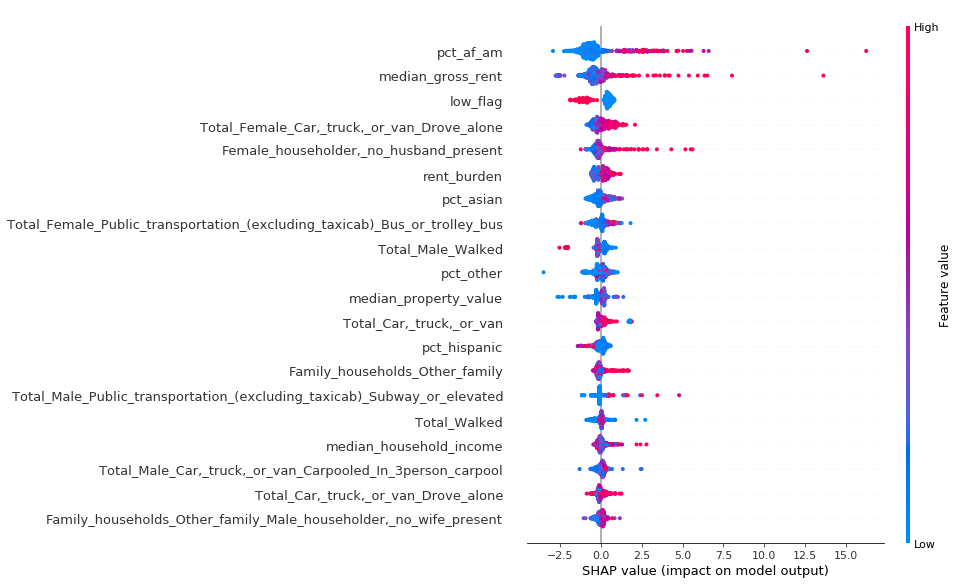

In [145]:
shap.summary_plot(shap_values, X_test)

In [146]:
X_test_pred = X_test.copy()
X_test_pred['shap_idx'] = range(499)

In [147]:
X_test['pct_af_am'] = X_test['pct_af_am']/100

In [148]:
X_test_pred.sort_values(by='Female_householder,_no_husband_present', ascending=False)['Female_householder,_no_husband_present']

266     0.238688
43      0.237903
1127    0.223945
291     0.222538
1880    0.219844
1970    0.218119
2155    0.213730
2040    0.212923
240     0.210942
332     0.207424
1891    0.203988
194     0.202459
1125    0.201595
1580    0.197002
2303    0.196129
196     0.195820
1116    0.195347
1867    0.192398
2007    0.191913
1868    0.191351
56      0.190928
891     0.184431
2257    0.184285
1163    0.183565
368     0.183285
212     0.182307
259     0.182250
48      0.181990
350     0.179041
1498    0.178425
          ...   
940     0.058114
2482    0.057913
1269    0.057385
1406    0.057382
1808    0.057269
1307    0.056159
1360    0.055975
2488    0.054948
679     0.052773
2060    0.052632
1421    0.049715
1075    0.049429
1399    0.047794
755     0.047538
1456    0.044805
1334    0.044245
1053    0.041908
764     0.040673
1285    0.038031
772     0.034568
1364    0.033223
1288    0.031538
1336    0.030844
727     0.028543
2057    0.021127
1376    0.020513
1413    0.019582
134     0.0194

In [149]:
shap.force_plot(explainer.expected_value, shap_values[60,:], X_test.iloc[60,:])

# Compare both models recommendations for impact on protected classes

In [150]:
X_test_geo['predictions_with_all_inputs'] = model.predict(d_test)
X_test_geo['predictions_exclude_protected_classes'] = modelp.predict(dp_test)

In [151]:
corr_X = X_test_geo.corr()

In [152]:
corr_X.loc['pct_white','predictions_with_all_inputs']

-0.29524266996266063

In [153]:
corr_X.loc['pct_af_am','predictions_with_all_inputs']

0.42524622105150806

In [154]:
corr_X.loc['pct_af_am','predictions_exclude_protected_classes']

0.37918101159810585

In [155]:
import seaborn as sns

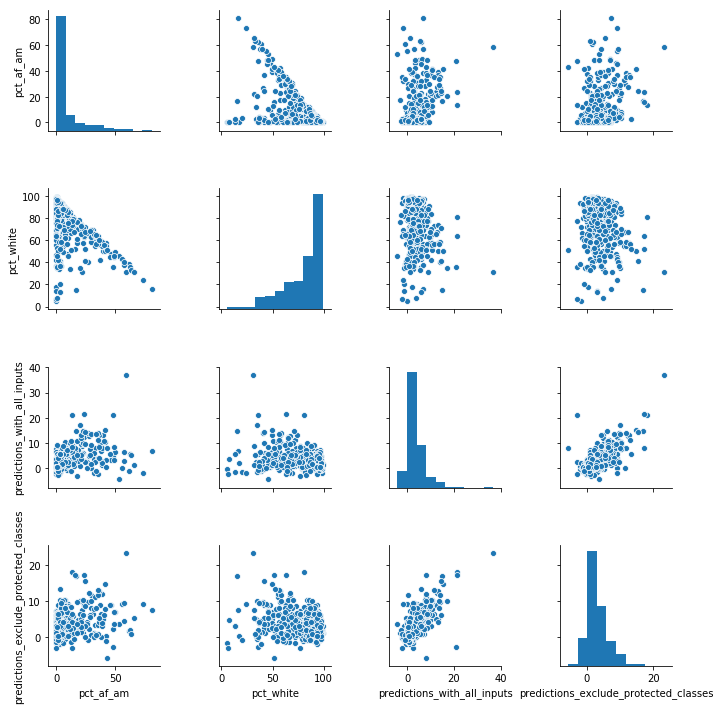

In [156]:
sns.pairplot(X_test_geo[['pct_af_am','pct_white','predictions_with_all_inputs','predictions_exclude_protected_classes']])

In [157]:
X_test_geo.sort_values(by=['pct_af_am'],ascending=False)

,geoid,name,parent_location,poverty_rate,pct_renter_occupied,median_gross_rent,median_household_income,median_property_value,rent_burden,pct_white,...,Total_Female_Public_transportation_(excluding_taxicab)_Streetcar_or_trolley_car_(carro_publico_in_Puerto_Rico),Total_Female_Public_transportation_(excluding_taxicab)_Subway_or_elevated,Total_Female_Public_transportation_(excluding_taxicab)_Railroad,Total_Female_Public_transportation_(excluding_taxicab)_Ferryboat,Total_Female_Bicycle,Total_Female_Walked,"Total_Female_Taxicab,_motorcycle,_or_other_means",Total_Female_Worked_at_home,predictions_with_all_inputs,predictions_exclude_protected_classes
43,1087,Macon County,Alabama,22.07,35.04,592.0,30738.0,74700.0,32.8,16.09,...,0.000000,0.000000,0.000000,0.000000,0.001627,0.040000,0.006237,0.008407,6.771185,7.425220
291,13141,Hancock County,Georgia,25.05,21.74,630.0,24925.0,66700.0,34.1,23.98,...,0.000000,0.002308,0.000000,0.000000,0.000000,0.000000,0.000000,0.018006,-1.834651,9.096933
1891,45089,Williamsburg County,South Carolina,24.18,26.48,569.0,28297.0,68300.0,33.4,31.37,...,0.000000,0.000000,0.000433,0.000000,0.000000,0.007880,0.000433,0.006754,1.167870,5.386544
1880,45061,Lee County,South Carolina,20.89,26.08,596.0,30954.0,69800.0,34.2,32.65,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.011263,0.008532,0.001024,5.423610,0.966938
1857,45009,Bamberg County,South Carolina,18.15,24.34,607.0,31314.0,63900.0,36.4,35.49,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.005837,0.000000,0.017877,5.683770,2.006238
1127,28065,Jefferson Davis County,Mississippi,26.58,23.59,697.0,26279.0,82300.0,44.8,38.41,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.001769,0.000000,0.008843,-0.910001,1.692454
891,22071,Orleans Parish,Louisiana,21.71,53.74,924.0,36792.0,192400.0,37.0,30.83,...,0.002433,0.000000,0.000163,0.000448,0.011457,0.021691,0.006846,0.022122,36.893600,23.248713
342,13263,Talbot County,Georgia,16.11,19.62,572.0,34078.0,72300.0,29.2,39.77,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.011028,0.024025,0.020481,3.025861,9.436993
2234,51081,Greensville County,Virginia,16.83,28.43,716.0,38012.0,99800.0,32.2,37.52,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002958,0.029332,0.004930,6.536310,4.368150
361,13307,Webster County,Georgia,15.82,15.91,553.0,37063.0,46000.0,19.3,43.20,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.005474,0.000000,0.000000,0.003017,9.136950


In [158]:
X_test.sort_values(by=['pct_af_am'], ascending=False)[:20]

,poverty_rate,pct_renter_occupied,median_gross_rent,median_household_income,median_property_value,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,...,Total_Female_Public_transportation_(excluding_taxicab),Total_Female_Public_transportation_(excluding_taxicab)_Bus_or_trolley_bus,Total_Female_Public_transportation_(excluding_taxicab)_Streetcar_or_trolley_car_(carro_publico_in_Puerto_Rico),Total_Female_Public_transportation_(excluding_taxicab)_Subway_or_elevated,Total_Female_Public_transportation_(excluding_taxicab)_Railroad,Total_Female_Public_transportation_(excluding_taxicab)_Ferryboat,Total_Female_Bicycle,Total_Female_Walked,"Total_Female_Taxicab,_motorcycle,_or_other_means",Total_Female_Worked_at_home
43,22.07,35.04,592.0,30738.0,74700.0,32.8,16.09,0.8086,1.56,0.27,...,0.009492,0.009492,0.000000,0.000000,0.000000,0.000000,0.001627,0.040000,0.006237,0.008407
291,25.05,21.74,630.0,24925.0,66700.0,34.1,23.98,0.7322,1.95,0.00,...,0.002308,0.000000,0.000000,0.002308,0.000000,0.000000,0.000000,0.000000,0.000000,0.018006
1891,24.18,26.48,569.0,28297.0,68300.0,33.4,31.37,0.6547,2.22,0.10,...,0.010132,0.009699,0.000000,0.000000,0.000433,0.000000,0.000000,0.007880,0.000433,0.006754
1880,20.89,26.08,596.0,30954.0,69800.0,34.2,32.65,0.6302,2.13,0.13,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011263,0.008532,0.001024
1857,18.15,24.34,607.0,31314.0,63900.0,36.4,35.49,0.6231,1.25,0.06,...,0.001277,0.001277,0.000000,0.000000,0.000000,0.000000,0.000000,0.005837,0.000000,0.017877
1127,26.58,23.59,697.0,26279.0,82300.0,44.8,38.41,0.6123,0.14,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001769,0.000000,0.008843
891,21.71,53.74,924.0,36792.0,192400.0,37.0,30.83,0.5901,5.47,0.15,...,0.039843,0.036798,0.002433,0.000000,0.000163,0.000448,0.011457,0.021691,0.006846,0.022122
342,16.11,19.62,572.0,34078.0,72300.0,29.2,39.77,0.5737,1.94,0.06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011028,0.024025,0.020481
2234,16.83,28.43,716.0,38012.0,99800.0,32.2,37.52,0.5730,3.84,0.24,...,0.008134,0.008134,0.000000,0.000000,0.000000,0.000000,0.000000,0.002958,0.029332,0.004930
361,15.82,15.91,553.0,37063.0,46000.0,19.3,43.20,0.5585,0.96,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005474,0.000000,0.000000


In [160]:
pearsonr(X_test_geo['pct_af_am'], X_test_geo['predictions_exclude_protected_classes'])

(0.3791810115981059, 1.649473490810458e-18)

In [161]:
pearsonr(X_test_geo['pct_af_am'], X_test_geo['predictions_with_all_inputs'])

(0.4252462210515078, 2.4769745264725857e-23)

In [162]:
X_test_geo.columns

Index(['geoid', 'name', 'parent_location', 'poverty_rate',
       'pct_renter_occupied', 'median_gross_rent', 'median_household_income',
       'median_property_value', 'rent_burden', 'pct_white', 'pct_af_am',
       'pct_hispanic', 'pct_am_ind', 'pct_asian', 'pct_nh_pi', 'pct_multiple',
       'pct_other', 'low_flag', 'imputed', 'subbed',
       'pct_public_health_insurance', 'pct_private_health_insurance',
       'Family_households', 'Family_households_Marriedcouple_family',
       'Family_households_Other_family',
       'Family_households_Other_family_Male_householder,_no_wife_present',
       'Female_householder,_no_husband_present', 'Nonfamily_households',
       'Nonfamily_households_Householder_living_alone',
       'Nonfamily_households_Householder_not_living_alone',
       'Total_Car,_truck,_or_van', 'Total_Car,_truck,_or_van_Drove_alone',
       'Total_Car,_truck,_or_van_Carpooled',
       'Total_Car,_truck,_or_van_Carpooled_In_2person_carpool',
       'Total_Car,_truck,_or_

In [171]:
final_corr_X = X_test_geo[['predictions_with_all_inputs','predictions_exclude_protected_classes',
                           'pct_white', 'pct_af_am','Female_householder,_no_husband_present',
                           'Family_households_Other_family','poverty_rate',
                           'median_gross_rent','median_household_income', 'rent_burden', 
                           'Total_Female_Car,_truck,_or_van_Drove_alone',
                           'Total_Car,_truck,_or_van_Drove_alone', 'pct_renter_occupied',
                          'Total_Walked']].corr()
final_corr_X.to_csv('final_corr.csv')

In [172]:
final_corr_X

,predictions_with_all_inputs,predictions_exclude_protected_classes,pct_white,pct_af_am,"Female_householder,_no_husband_present",Family_households_Other_family,poverty_rate,median_gross_rent,median_household_income,rent_burden,"Total_Female_Car,_truck,_or_van_Drove_alone","Total_Car,_truck,_or_van_Drove_alone",pct_renter_occupied,Total_Walked
predictions_with_all_inputs,1.000000,0.704410,-0.295243,0.425246,0.393049,0.355809,0.072594,0.463457,0.181565,0.337570,0.178877,0.117659,0.356323,-0.208609
predictions_exclude_protected_classes,0.704410,1.000000,-0.298612,0.379181,0.434122,0.415396,0.125029,0.381589,0.089200,0.295055,0.262567,0.262649,0.329600,-0.280863
pct_white,-0.295243,-0.298612,1.000000,-0.594461,-0.648738,-0.624488,-0.433035,-0.262969,0.111023,-0.201014,-0.065284,-0.016718,-0.390440,0.167583
pct_af_am,0.425246,0.379181,-0.594461,1.000000,0.671007,0.591742,0.428628,0.082839,-0.258420,0.353518,0.341358,0.136790,0.222272,-0.185920
"Female_householder,_no_husband_present",0.393049,0.434122,-0.648738,0.671007,1.000000,0.960198,0.700626,0.051760,-0.376202,0.438286,0.422679,0.272188,0.334680,-0.395469
Family_households_Other_family,0.355809,0.415396,-0.624488,0.591742,0.960198,1.000000,0.693404,0.047270,-0.362772,0.415555,0.422448,0.303509,0.313471,-0.422034
poverty_rate,0.072594,0.125029,-0.433035,0.428628,0.700626,0.693404,1.000000,-0.338254,-0.742101,0.411684,0.230318,0.098425,0.267717,-0.165273
median_gross_rent,0.463457,0.381589,-0.262969,0.082839,0.051760,0.047270,-0.338254,1.000000,0.675374,0.195831,-0.141074,-0.083765,0.299359,-0.054594
median_household_income,0.181565,0.089200,0.111023,-0.258420,-0.376202,-0.362772,-0.742101,0.675374,1.000000,-0.314825,-0.217185,-0.045292,-0.063755,0.013118
rent_burden,0.337570,0.295055,-0.201014,0.353518,0.438286,0.415555,0.411684,0.195831,-0.314825,1.000000,0.304249,0.139248,0.217143,-0.210450


In [ ]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print("Explainer expected value: {}".format(expected_value))

select = range(20)
features = X_test.iloc[select]
features_display = X.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

In [ ]:
shap_values

In [ ]:
shap.summary_plot(shap_values,X_test)

In [ ]:
shap.decision_plot(expected_value, shap_values, features_display)

In [ ]:
shap.decision_plot(expected_value, shap_values, features_display, link='logit')

In [ ]:
#example code
from pprint import pprint
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pickle
import shap
from sklearn.model_selection import train_test_split, StratifiedKFold
import warnings

X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# create a train/test split
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "random_state": random_state
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

In [ ]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print("Explainer expected value: {}".format(expected_value))

select = range(20)
features = X_test.iloc[select]
features_display = X_display.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

In [ ]:
shap.decision_plot(expected_value, shap_values, features_display)

In [ ]:
shap.decision_plot(expected_value, shap_values, features_display, link='logit')

# Other data categories

In [ ]:
#TODO: Incorporate travel time
#DON'T USE???
df_travel = pd.read_csv('data/census/AGGREGATE TRAVEL TIME TO WORK/ACS_16_5YR_B08135_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_travel.columns = df_travel.columns.droplevel(0)
renames = {}
for col in df_travel.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]

df_travel = df_travel.rename(columns = renames)

drops = ['Id','Geography']
for col in df_travel.columns:
    if 'Margin' in col:
        drops.append(col)
        
df_travel.drop(drops, axis=1, inplace = True)
df_travel.dropna(inplace=True)

In [ ]:
#TODO: incorporate transportation by age
#DON'T INCLUDE???
df_transage = pd.read_csv('data/census/MEANS OF TRANSPORTATION TO WORK BY AGE/ACS_16_5YR_B08101_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_transage.columns = df_transage.columns.droplevel(0)

renames = {}
for col in df_transage.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]
df_transage = df_transage.rename(columns = renames)

drops = ['Id','Geography']
for col in df_transage.columns:
    if 'Margin' in col:
        drops.append(col)
df_transage.drop(drops, axis=1, inplace = True)
df_transage.dropna(inplace=True)

In [ ]:
#TODO: incorporate transportation by poverty status
#DON'T INCLUDE????
df_transpov = pd.read_csv('data/census/MEANS OF TRANSPORTATION TO WORK BY POVERTY STATUS/ACS_16_5YR_B08122_with_ann.csv',
                       encoding='ISO-8859-1', header=[0,1])
df_transpov.columns = df_transpov.columns.droplevel(0)

renames = {}
for col in df_transpov.columns:
    replaces = [(";",""), ("-",""), (":",""), ("Estimate ",""),(" ","_"),("__","_") ]
    t = col
    for word, new_word in replaces:
        renames[col] = t.replace(word, new_word)
        t = renames[col]
df_transpov = df_transpov.rename(columns = renames)

drops = ['Id','Geography']
for col in df_transpov.columns:
    if 'Margin' in col:
        drops.append(col)
df_transpov.drop(drops, axis=1, inplace = True)
df_transpov.dropna(inplace=True)